# Model calibration

## Necessary functions

In [147]:
from sklearn.calibration import calibration_curve
#average gap across all bins in a reliability diagram, weighted by the number of instances in each bin
from pycalib.metrics import binary_ECE
#1/N*sum((y_hat - y_true)^2)
from sklearn.metrics import brier_score_loss
#-1/N*sum(y_true*log(y_hat) + (1 - y_true*log(1 - y_hat)))
from sklearn.metrics import log_loss

def plot_calibration_curve(y_true, y_hat, name, title):
    """Plot calibration curve"""

    fig = plt.figure()
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan = 2)
    ax2 = plt.subplot2grid((4, 1), (3, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label= "Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_true, y_hat, n_bins = 10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label = f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc = "lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(y_hat, range=(0, 1), bins = 10, label = name, histtype = "step", lw = 2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    
    fig.savefig(title, bbox_inches='tight', dpi=150)
    
def eval_cali(y_true, y_hat, name, title):
    plot_calibration_curve(y_true, y_hat, name, title)
    ECE = binary_ECE(y_true, y_hat)
    brier_loss = brier_score_loss(y_true, y_hat)
    ce_loss = log_loss(y_true, y_hat, eps = 1e-6)
    print("ECE: " + str(ECE))
    print("brier score: " + str(brier_loss))
    print("crossentropy loss: " + str(ce_loss))

In [148]:
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np
from scipy.stats import chi2

def HosmerLemeshow(y_hat, y_true, bins):
    #sort the data
    inds = np.argsort(y_hat)
    y_hat = y_hat[inds]
    y_true = y_true[inds]
    binned = []
    
    #bin the data in equally-sized bins
    cuts = [i/bins for i in range(bins + 1)]
    binned_y_hat = [y_hat[int(np.round(cuts[i]*len(y_hat))):int(np.round(cuts[i + 1]*len(y_hat)))] for i in range(len(cuts) - 1)]
    binned_y_true = [y_true[int(np.round(cuts[i]*len(y_true))):int(np.round(cuts[i + 1]*len(y_true)))] for i in range(len(cuts) - 1)]

    H = 0
    eps = 0.001
    
    #calculate the hosmer statistic
    for i in range(bins):
        bin_len = len(binned_y_true[i])
        observed_1 = eps + sum(binned_y_true[i])
        expected_1 = eps + np.mean(binned_y_hat[i])*bin_len
        observed_0 = eps + bin_len - observed_1
        expected_0 = 2*eps + bin_len - expected_1
        
        H += (((observed_1 - expected_1)**2)/expected_1) + (((observed_0 - expected_0)**2)/expected_0)
        
    print(H)
    #determine the p-value
    pvalue = 1 - chi2.cdf(H, bins - 2)
    
    return pvalue, binned_y_hat, binned_y_true

In [149]:
"""
#can be used to make graphs of equally sized bins
mean_predicted_value = []
fraction_of_positives = []

for i in range(len(b_y_hat)):
    mean_predicted_value.append(np.mean(b_y_hat[i]))
    fraction_of_positives.append(sum(b_y_true[i])/len(b_y_true[i]))
    
#adapted version of the kolmogorov-smirnof statistical test
from scipy.stats import ks_2samp
ks_2samp(mean_predicted_value, fraction_of_positives)

#plot calibration curve with equally sized bins
plt.scatter(mean_predicted_value, fraction_of_positives)
plt.xlabel("mean predicted values")
plt.ylabel("fraction of positives")
plt.title("uncalibrated")
"""

'\n#can be used to make graphs of equally sized bins\nmean_predicted_value = []\nfraction_of_positives = []\n\nfor i in range(len(b_y_hat)):\n    mean_predicted_value.append(np.mean(b_y_hat[i]))\n    fraction_of_positives.append(sum(b_y_true[i])/len(b_y_true[i]))\n    \n#adapted version of the kolmogorov-smirnof statistical test\nfrom scipy.stats import ks_2samp\nks_2samp(mean_predicted_value, fraction_of_positives)\n\n#plot calibration curve with equally sized bins\nplt.scatter(mean_predicted_value, fraction_of_positives)\nplt.xlabel("mean predicted values")\nplt.ylabel("fraction of positives")\nplt.title("uncalibrated")\n'

## Load y_hat and y_true data

In [173]:
y_hat_test = np.load('/home/yarivl/thesis/results/Transformer/E_coli/y_hat_test.npy')
y_true_test = np.load('/home/yarivl/thesis/results/Transformer/E_coli/y_true_test.npy')
y_hat_val = np.load('/home/yarivl/thesis/results/Transformer/E_coli/y_hat_val.npy')
y_true_val = np.load('/home/yarivl/thesis/results/Transformer/E_coli/y_true_val.npy')

## Evaluate uncalibrated validation set

In [174]:
p_val, b_y_hat, b_y_true = HosmerLemeshow(y_hat_val, y_true_val, 10)

12114.171386298105


In [175]:
p_val

0.0

ECE: 0.003756663709487395
brier score: 0.013734182410619284
crossentropy loss: 0.043346036860119966


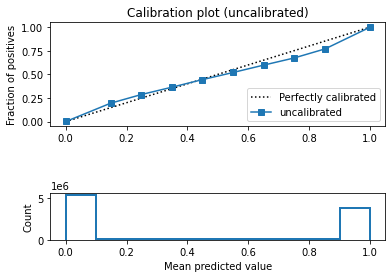

In [176]:
eval_cali(y_true_val, y_hat_val, "uncalibrated", "t_ecol_val_uncal.png")

## Evaluate calibrated validation set

### Isotonic regression

In [177]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds = 'clip').fit(y_hat_val, y_true_val)
y_cal_val_isotonic = iso_reg.predict(y_hat_val)

In [178]:
p_val_iso, b_y_hat_iso, b_y_true_iso = HosmerLemeshow(y_cal_val_isotonic, y_true_val, 10)

1.1652959235274123


In [179]:
p_val_iso

0.9969729941368245

ECE: 6.504657648732388e-07
brier score: 0.01352026911221503
crossentropy loss: 0.04226128187423192


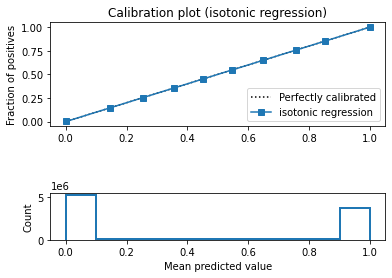

In [180]:
eval_cali(y_true_val, y_cal_val_isotonic, "isotonic regression", "t_ecol_val_iso.png")

### Platt scaling

In [181]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(y_hat_val.reshape(-1, 1), y_true_val)
y_cal_val_logistic = log_reg.predict(y_hat_val.reshape(-1, 1))

In [182]:
p_val_log, b_y_hat_log, b_y_true_log = HosmerLemeshow(y_cal_val_logistic, y_true_val, 10)

3953164546707.1787


In [183]:
p_val_log

0.0

ECE: 0.019808146227271603
brier score: 0.0198081350753085
crossentropy loss: 0.2735318380175713


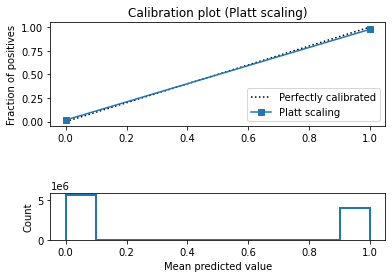

In [184]:
eval_cali(y_true_val, y_cal_val_logistic, "Platt scaling", "t_ecol_val_pla.png")

## Evaluate uncalibrated test set

In [185]:
p_test, b_y_hat_test, b_y_true_test = HosmerLemeshow(y_hat_test, y_true_test, 10)

18507.896838778728


In [186]:
p_test

0.0

ECE: 0.004492588218218394
brier score: 0.013828768500380874
crossentropy loss: 0.043285351718119085


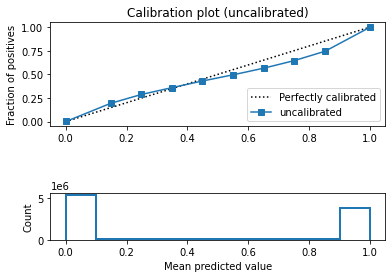

In [187]:
eval_cali(y_true_test, y_hat_test, "uncalibrated", "t_ecol_test_uncal.png")

## Evaluate calibrated test set

### Isotonic regression

In [188]:
y_cal_test_isotonic = iso_reg.predict(y_hat_test)

In [189]:
p_test_iso, b_y_hat_iso_test, b_y_true_iso_test = HosmerLemeshow(y_cal_test_isotonic, y_true_test, 10)

857.8910790720374


In [190]:
p_test_iso

0.0

ECE: 0.0010817042882749282
brier score: 0.01352334657875484
crossentropy loss: 0.041889002132678314


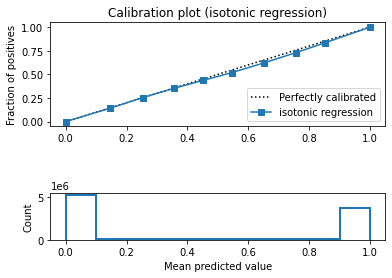

In [191]:
eval_cali(y_true_test, y_cal_test_isotonic, "isotonic regression", "t_ecol_test_iso.png")

### Platt scaling

In [192]:
y_cal_test_logistic = log_reg.predict(y_hat_test.reshape(-1, 1))

In [193]:
p_test_log, b_y_hat_log, b_y_true_log = HosmerLemeshow(y_cal_test_logistic, y_true_test, 10)

3404020074365.7476


In [194]:
p_test_log

0.0

ECE: 0.020067920029195004
brier score: 0.020067924184498348
crossentropy loss: 0.27711390048357604


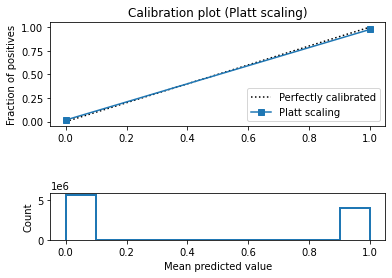

In [195]:
eval_cali(y_true_test, y_cal_test_logistic, "Platt scaling", "t_ecol_test_pla.png")

## Store new calibrated test values

In [61]:
#np.save('/home/yarivl/thesis/results/Transformer/E_coli/y_cal_test_isotonic.npy', y_cal_test_isotonic)

In [196]:
#calculate precision, recall, false positive rate, true positive rate
fpr, tpr, thresholds_ROC = roc_curve(y_true_test, y_hat_test)
precision, recall, thresholds_PR = precision_recall_curve(y_true_test, y_hat_test)

#calculate area under the curve
AUC_ROC = metrics.auc(fpr, tpr)
AUC_PR = average_precision_score(y_true_test, y_hat_test)
print("AUC_ROC: " + str(AUC_ROC))
print("AUC_PR: " + str(AUC_PR))


AUC_ROC: 0.998822791385784
AUC_PR: 0.9984101359154731


In [197]:
acc = accuracy_score(y_true_test, np.round(y_hat_test))
prec = precision_score(y_true_test, np.round(y_hat_test))
rec = recall_score(y_true_test, np.round(y_hat_test))

In [198]:
print("accuracy: " + str(acc))
print("precision: " + str(prec))
print("recall: " + str(rec))

accuracy: 0.9798770789964969
precision: 0.9743918146014177
recall: 0.9773680772084637


In [97]:
#calculate precision, recall, false positive rate, true positive rate
fpr, tpr, thresholds_ROC = roc_curve(y_true_test, y_cal_test_isotonic)
precision, recall, thresholds_PR = precision_recall_curve(y_true_test, y_cal_test_isotonic)

#calculate area under the curve
AUC_ROC = metrics.auc(fpr, tpr)
AUC_PR = average_precision_score(y_true_test, y_cal_test_isotonic)
print("AUC_ROC: " + str(AUC_ROC))
print("AUC_PR: " + str(AUC_PR))


AUC_ROC: 0.993325834190382
AUC_PR: 0.9917748773987703


In [98]:
acc = accuracy_score(y_true_test, np.round(y_cal_test_isotonic))
prec = precision_score(y_true_test, np.round(y_cal_test_isotonic))
rec = recall_score(y_true_test, np.round(y_cal_test_isotonic))

In [99]:
print("accuracy: " + str(acc))
print("precision: " + str(prec))
print("recall: " + str(rec))

accuracy: 0.9521761151720555
precision: 0.9426752878110658
recall: 0.9424801031333173


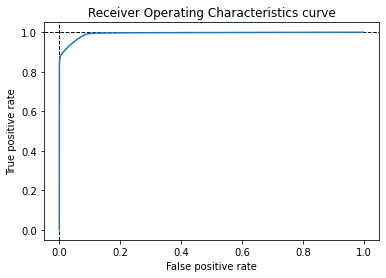

In [172]:
fig, ax = plt.subplots()
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Receiver Operating Characteristics curve')
ax.axvline(x = 0, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
ax.plot(fpr, tpr)

fig.savefig("roc, bbox_inches='tight', dpi=150)

plt.show()

In [199]:
y_hat_test_t = np.load('/home/yarivl/thesis/results/Transformer/E_coli/y_cal_test_isotonic.npy')
y_true_test = np.load('/home/yarivl/thesis/results/Transformer/E_coli/y_true_test.npy')
y_hat_test_c = np.load('/home/yarivl/thesis/results/ConvNeXt/E_coli/y_cal_test_isotonic.npy')

In [200]:
fpr1, tpr1, thresholds_ROC1 = roc_curve(y_true_test, y_hat_test_c)
fpr2, tpr2, thresholds_ROC2 = roc_curve(y_true_test, y_hat_test_t)

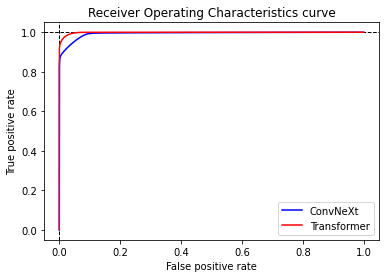

In [207]:
fig, ax = plt.subplots()
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Receiver Operating Characteristics curve')
ax.axvline(x = 0, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
ax.plot(fpr1, tpr1, "b-", label = f'{"ConvNeXt"}')
ax.plot(fpr2, tpr2, "r-", label = f'{"Transformer"}')
ax.legend(loc = "lower right")

fig.savefig("roc_ecol", bbox_inches='tight', dpi=150)

plt.show()

In [208]:
precision1, recall1, thresholds_PR1 = precision_recall_curve(y_true_test, y_hat_test_c)
precision2, recall2, thresholds_PR2 = precision_recall_curve(y_true_test, y_hat_test_t)

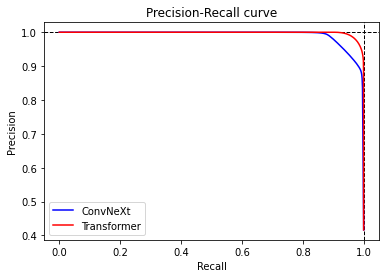

In [211]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')
ax.axvline(x = 1, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
ax.plot(recall1, precision1, "b-", label = f'{"ConvNeXt"}')
ax.plot(recall2, precision2, "r-", label = f'{"Transformer"}')
#ax.plot(recall[:1935769], thresholds_PR, color = 'orange')
ax.legend(loc = "lower left")

fig.savefig("pr_ecol", bbox_inches='tight', dpi=150)

plt.show()